<a href="https://colab.research.google.com/github/AnnaZhuravleva/avtobreja/blob/master/Aspect_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install innvestigate

In [2]:
!pip install tensorflow==1.14.0

In [3]:
!pip install tqdm

In [0]:
!wget http://vectors.nlpl.eu/repository/11/180.zip

In [104]:
!unzip 180.zip

Archive:  180.zip
  inflating: README                  
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               


In [7]:
import innvestigate
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

from collections import Counter
from gensim.models import KeyedVectors
from itertools import chain
from innvestigate.utils.tests.networks import base as network_base
from matplotlib import cm, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### Данные
Каждый текст - строчка из токенов лемма_тег. Оценки отдельно выведены для сервиса, отдельно для еды. Мы будем строить бинарную классификацию, поэтому будем считать оценки выше 5 положительными, а 5 и ниже — отрицательными.

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [11]:
scored = pd.read_csv("/content/drive/My Drive/studies/HSE/prog/nlp/proj/SentiRuEval_rest_train_lemma_POS.csv", index_col=0)
scored.tail()

,food,service,text,lemma_POS
19029,2,3,"С тех пор, как побывала последний раз, мнение ...","с_ADP тот_DET пора_NOUN ,_PUNCT как_SCONJ быва..."
19030,1,1,Обнаруженный в салате таракан очень поразил!!!...,обнаружить_VERB в_ADP салат_NOUN таракан_NOUN ...
19031,6,5,Забавное заведение. Симпатичный светлый интерь...,забавный_ADJ заведение_NOUN ._PUNCT симпатичны...
19032,8,9,Поздравляем администрацию ресторана Навруз с Н...,поздравлять_VERB администрация_NOUN ресторан_N...
19033,8,8,Очень нравиться интерьер. Отличный гриль.Карта...,очень_ADV нравиться_VERB интерьер_NOUN ._PUNCT...


In [14]:
scored.drop(["text", "lemma_POS"], axis=1).mean(axis=0)

food       7.140065
service    6.987233
dtype: float64

In [19]:
scored.drop(["text", "lemma_POS"], axis=1).median(axis=0)

food       8.0
service    8.0
dtype: float64

In [20]:
scored.drop(["text", "lemma_POS"], axis=1).mode(axis=0)

,food,service
0,10,10


In [40]:
scored.drop(["text", "lemma_POS"], axis=1).quantile(q=0.25, axis=0)

food       6.0
service    5.0
Name: 0.25, dtype: float64

In [42]:
scored.drop(["text", "lemma_POS"], axis=1).quantile(q=0.15, axis=0)

food       3.0
service    3.0
Name: 0.15, dtype: float64

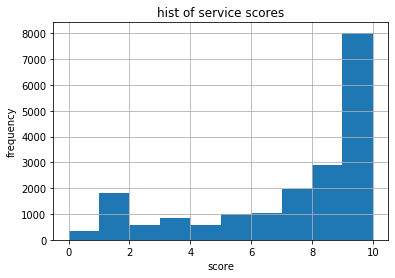

In [24]:
scored["service"].hist()
plt.xlabel("score")
plt.ylabel("frequency")
plt.title("hist of service scores");

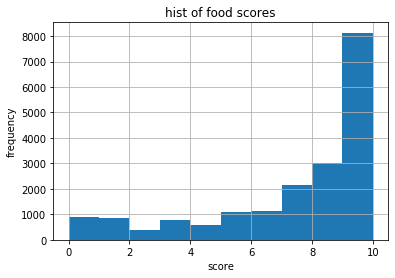

In [25]:
scored["food"].hist()
plt.xlabel("score")
plt.ylabel("frequency")
plt.title("hist of food scores");

In [34]:
excellent_food = scored["food"] == 10
excellent_service = scored["service"] == 10
len(scored[excellent_food & excellent_service]) / len(scored)
## where both are 10 = 17%

0.16759483030366712

In [33]:
horrible_food = scored["food"] == 0
horrible_service = scored["service"] == 0
len(scored[horrible_food & horrible_service]) / len(scored)
## where both are 0 = 0.5%

0.005989282336870863

In [37]:
len(scored[horrible_food != horrible_service]) / len(scored)
## either one or the other is 0 but not both = 0.2%

0.0028370284753598822

In [50]:
good_food = scored["food"] > 8
good_service = scored["service"] > 8
len(scored[good_food & good_service]) / len(scored)
## where both are above 8 = 31%

0.31527792371545654

In [66]:
bad_food = scored["food"] <= 4
bad_service = scored["service"] <= 4
len(scored[bad_food & bad_service]) / len(scored)
## where both are below or at 4 = 11%

0.11936534622254913

In [68]:
ok_food = scored["food"] >= 7
ok_service = scored["service"] >= 7
len(scored[ok_food & ok_service]) / len(scored)
## where both are above or at 7 = 58%

0.5896290847956289

In [69]:
len(scored[(bad_food & ok_service) | (ok_food & bad_service)]) / len(scored)

0.10076704843963434

In [0]:
aspect_scored = scored.loc[(bad_food & ok_service) | (ok_food & bad_service)]

In [99]:
aspect_scored["aspect"] = scored.loc[(bad_food & ok_service) | (ok_food & bad_service), "food"].apply(lambda n: 1 if n >= 7 else 0)
aspect_scored.tail()

,food,service,text,lemma_POS,aspect
19006,7,3,РЕспект за кухню. Обслуживание не супер - смущ...,респект_NOUN за_ADP кухня_NOUN ._PUNCT обслужи...,1
19007,0,10,"То, что есть в коктейльной карте - процентов 1...","то_PRON ,_PUNCT что_PRON быть_VERB в_ADP кокте...",0
19015,10,2,"Здравствуйте! Стыдно, что в Бричмуле работают ...","здравствовать_VERB !_PUNCT стыдно_ADJ ,_PUNCT ...",1
19026,9,3,Доброго вечера ! Хочу высказать свое мнение по...,добрый_ADJ вечер_NOUN !_PUNCT хотеть_VERB выск...,1
19028,4,8,"Вот думала, писать-не писать... Если честно, т...","вот_PART думать_VERB ,_PUNCT писать_VERB _PUNC...",0


Аспект 1 - еда, аспект 0 - сервис.

In [0]:
texts = list(aspect_scored["lemma_POS"].apply(lambda s: s.split()))

In [0]:
scores = list(aspect_scored["aspect"])

In [106]:
w2v_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Оценка тональности с помощью CNN

В качестве входных представлений будем использовать word2vec для лемм с POS-тегами UD.
Архитектура классификатора примерно воспроизводит описанную в [статье Arras et al. 2017](http://www.aclweb.org/anthology/W16-1601); а для визуализации воспользуемся библиотекой [iNNvestigate](https://github.com/albermax/innvestigate).

Картинка про классификатор и оценку значимости входных слов ([источник](https://doi.org/10.1371/journal.pone.0181142.g001)):
<img src="https://camo.githubusercontent.com/ba37f37fdbb90ccd76f1c4bf399e0cb8ddbc66f0/68747470733a2f2f692e696d6775722e636f6d2f595144665335502e706e67"/>

### CNN functions

In [0]:
def max_length(texts):
    return max(len(t) for t in texts)
    
def to_one_hot(y):
    return keras.utils.to_categorical(y, 2)

In [0]:
def load_dataset(w2v_model, lines, MAX_LEN, num_examples=None):
    """
    embedds a list of texts with a w2v model

    :param w2v_model: gensim KeyedVectors model
    :param lines: list of lists of str, texts of words (pre-processed to be model-compatible)
    :param MAX_LEN: int, maximal text length for padding
    :param num_examples: int, number of texts to add to dataset, optional, default None 

    :return x_tensor: np.ndarray, embedded texts
    :return vocab: counter, how many times words occured in texts
    """
    embedding_dim = w2v_model.vector_size
    prep = lines[:num_examples]
    vocab = Counter()
    x_tensor = np.zeros((len(prep), MAX_LEN, embedding_dim))
    for i, text in enumerate(prep):
        for j, w in enumerate(text):
            try:
                x_tensor[i, j, :] = w2v_model[w]
            except KeyError:
                pass
        vocab[w] += 1
    return x_tensor, vocab

In [0]:
def make_dataset_for_training_cnn(w2v_model, texts, scores):
  """
  vectorizes dataset from a list of texts and scores (do not give more than 2000, as more eats all RAM)

  :param w2v_model: gensim KeyedVectors model
  :param texts: list of lists of str, texts of words
  :param scores: list of int, target text scores

  :return MAX_LEN: int, maximal text length for padding
  :return scores_train: list of int, traing scores
  :return scores_val: list of int, validation scores
  :return texts_train: list of lists of str, traing texts
  :return texts_val: list of lists of str, validation texts
  :return input_tensor_train: np.ndarray, embedded traing texts
  :return inp_vocab_train: counter, traing texts vocabulary
  :return input_tensor_val: np.ndarray, embedded validation texts
  :return inp_vocab_val: counter, validation texts vocabulary
  """
  if len(texts) != len(scores):
    raise ValueError(f"expected texts and scores of the same length but got lengths {len(texts)} and {len(scores)}")
  scores = np.array(scores).astype(int)
  scores_train, scores_val, texts_train, texts_val = train_test_split(scores, texts, test_size=0.3, shuffle=False)
  MAX_LEN = max(max_length(texts_train), max_length(texts_val))
  input_tensor_train, inp_vocab_train = load_dataset(w2v_model, texts_train, MAX_LEN)
  input_tensor_val, inp_vocab_val = load_dataset(w2v_model, texts_val, MAX_LEN)
  return MAX_LEN, scores_train, scores_val, texts_train, texts_val, input_tensor_train, inp_vocab_train, input_tensor_val, inp_vocab_val

In [0]:
def build_network(max_len, voc_size, embedding_dim, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    """
    builds a keras cnn structure

    :param max_len: int, sequence length
    :param voc_size: int, number of words in vocabulary
    :param embedding_dim: int, dimensionality of w2v model
    :param output_n: int, number of classes
    :param activation: pre-trained weights, optional, default None
    :param dense_unit: int, optional, dimensionality of the dense unit 
    :param dropout_rate: float, optional, default=0.25

    :return: keras nn
    """
    if activation:
        activation = "relu"

    net = {}
    net["in"] = keras.Input(shape=[1, max_len, embedding_dim])
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, max_len - 1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": [1, max_len, embedding_dim],
        "output_n": output_n,
    })
    return net

In [0]:
def train_model(model, input_tensor_train, input_tensor_val, scores_train, scores_val, epochs=20):
    """
    training keras nn

    :param model: keras nn
    :param input_tensor_train: np.ndarray, training set
    :param input_tensor_val: np.ndarray, validation set
    :param scores_train: list of int, traing scores
    :param scores_val: list of int, validation scores
    :param epochs: int, optional, default 20
    """
    x_train = np.expand_dims(input_tensor_train, axis=1)
    y_train = to_one_hot(scores_train)
    
    x_val = np.expand_dims(input_tensor_val, axis=1)
    y_val = to_one_hot(scores_val)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=256,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True)

In [0]:
def train_network(w2v_model, texts_train, texts_val, scores_train, scores_val, inp_vocab_train, inp_vocab_val, input_tensor_train, input_tensor_val, MAX_LEN, epochs=20):
  """
  trains two cnn models form split dataset

  :param w2v_model: gensim KeyedVectors model
  :param texts_train: list of lists of str, traing texts
  :param texts_val: list of lists of str, validation texts
  :param scores_train: list of int, traing scores
  :param scores_val: list of int, validation scores
  :param inp_vocab_train: counter, traing texts vocabulary
  :param inp_vocab_val: counter, validation texts vocabulary
  :param input_tensor_train: np.ndarray, training set
  :param input_tensor_val: np.ndarray, validation set
  :param MAX_LEN: int, sequence length
  :param epochs: int, optional, default 20

  :return model_without_softmax: keras nn, without classifier layer
  :return model_with_softmax: keras nn, with classifier layer
  :return embedding_dim: int, dimension of w2v
  """
  embedding_dim = w2v_model.vector_size
  inp_vocab = inp_vocab_train + inp_vocab_val
  vocab_inp_size = len(inp_vocab) + 1
  net = build_network(MAX_LEN, vocab_inp_size, embedding_dim, 2)
  model_without_softmax = keras.models.Model(inputs=net['in'], outputs=net['out'])
  model_with_softmax = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])
  train_model(model_with_softmax, input_tensor_train, input_tensor_val, scores_train, scores_val, epochs)
  model_without_softmax.set_weights(model_with_softmax.get_weights())
  return model_without_softmax, model_with_softmax, embedding_dim

In [0]:
def analyze_scores(X, Y, ridx, embedding_dim, model_without_softmax, model_with_softmax, analyzers, max_len):
    """
    predicts individual word scores and text score

    :param X: np.ndarray, embedded texts tensor
    :param Y: list of int, target classes
    :param ridx: int, text id 
    :param model_without_softmax: keras nn, without classifier layer
    :param model_with_softmax: keras nn, with classifier layer
    :param embedding_dim: int, dimension of w2v
    :param analyzers: list of innvestigate analyzers
    :param max_len: int, sequence length

    :return analysis: list of list of float, word weights according to each analyzer
    :return y_hat: int, calss prediction
    """
    analysis = np.zeros([len(analyzers), 1, max_len])
    x, y = X[ridx], Y[ridx]
    t_start = time.time()
    x = x.reshape((1, 1, max_len, embedding_dim))
    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
  
    for aidx, analyzer in enumerate(analyzers):
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analysis[aidx] = a
    t_elapsed = time.time() - t_start
    # print('Review %d (%.4fs)'% (ridx, t_elapsed))
    return analysis, y_hat

In [0]:
def get_sentiment_vocabulary(w2v_model, texts, scores, sentiment_scores=None, only_correct=True, epochs=10):
  """
  gets sentiment vocabulary from texts

  :param w2v_model: gensim KeyedVectors model
  :param texts: list of lists of str, texts of words
  :param scores: list of int, target text scores 
  :param sentiment_scores: counter of words to update, optional, default None
  :param only_correct: bool, if only use the weights from correct predictions, optional, default True
  :param epochs: int, cnn training param, optional, default 10

  :return: counter, words and their sentiment weights
  """
  print("__making the dataset__")
  MAX_LEN, scores_train, scores_val, texts_train, texts_val, input_tensor_train, inp_vocab_train, input_tensor_val, inp_vocab_val = make_dataset_for_training_cnn(w2v_model, texts, scores)
  print("__training the network__")
  model_without_softmax, model_with_softmax, embedding_dim = train_network(w2v_model, texts_train, texts_val, scores_train, scores_val, inp_vocab_train, inp_vocab_val, input_tensor_train, input_tensor_val, MAX_LEN, epochs=epochs)

  print("__making the analyzers__")
  methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
  kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]
  analyzers = []
  for method, kws in zip(methods, kwargs):
      analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
      analyzer.fit(np.expand_dims(input_tensor_train, axis=1), batch_size=256, verbose=1)
      analyzers.append(analyzer)

  if not sentiment_scores:
    sentiment_scores = [Counter() for method in methods]
  
  for idx in tqdm(range(len(input_tensor_train)), desc="__building the sentiment vocabulary on training set__"):
    words = texts_train[idx]
    y_true = scores_train[idx]
    a, y_pred = analyze_scores(input_tensor_train, scores_train, idx, embedding_dim, model_without_softmax, model_with_softmax, analyzers, MAX_LEN)
    if only_correct and y_true == y_pred or not only_correct:
      for j, method in enumerate(methods):
        sentiment_scores[j].update(dict(zip(words, a[j].reshape(-1))))

  for idx in tqdm(range(len(input_tensor_val)), desc="__building the sentiment vocabulary on validation set__"):
    words = texts_val[idx]
    y_true = scores_val[idx]
    a, y_pred = analyze_scores(input_tensor_val, scores_val, idx, embedding_dim, model_without_softmax, model_with_softmax, analyzers, MAX_LEN)
    if only_correct and y_true == y_pred or not only_correct:
      for j, method in enumerate(methods):
        sentiment_scores[j].update(dict(zip(words, a[j].reshape(-1))))
  return sentiment_scores

## Aspect classification


In [118]:
asp = get_sentiment_vocabulary(w2v_model, texts, scores, epochs=10)

__making the dataset__
__training the network__






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1342 samples, validate on 576 samples
Epoch 1/10
1342/1342 [==============================] - 9s 7ms/step - loss: 4.4634 - acc: 0.3994 - val_loss: 1.6237 - val_acc: 0.5590
Epoch 2/10
1342/1342 [==============================] - 9s 7ms/step - loss: 1.8970 - acc: 0.6118 - val_loss: 1.8155 - val_acc: 0.5625
Epoch 3/10
1342/1342 [==============================] - 9s 7ms/step - loss: 0.8861 - acc: 0.6841 - val_loss: 1.0219 - val_acc: 0.5642
Epoch 4/10
1342/1342 [==============================] - 9s 7ms/step - loss: 0.8316 - acc: 0.6215 - val_loss: 0.7299 - val_acc: 0.6719
Epoch 5/10
1342/1342 [==============================] - 9s 7ms/step - loss: 0.5279 - acc: 0.7645 - val_loss: 0.8846 - val_acc: 0.6128
Epoch 6/10
1342/1342 [==============================] - 9s 7ms/step - loss: 0.3902 - acc: 0.8197 - val_loss: 0.7219 - val_acc: 0.6927


/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
6/6 [==============================] - 14s 2s/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


__building the sentiment vocabulary on training set__: 100%|██████████| 1342/1342 [01:09<00:00, 19.24it/s]
__building the sentiment vocabulary on validation set__: 100%|██████████| 576/576 [00:29<00:00, 19.31it/s]


In [130]:
asp[0]['вкусно_ADV']

1.4380867704749107

In [133]:
asp[0]['блюдо_NOUN']

10.717518095392734

In [132]:
asp[0]['быстро_ADV']

3.8413307707523927

In [120]:
asp[0]['официантка_NOUN']

14.03184444620274

In [126]:
asp[0].most_common(50)

[('атмосфера_NOUN', 48.521968096494675),
 ('зал_NOUN', 35.859237205731915),
 ('интерьер_NOUN', 31.756325804628432),
 ('кухня_NOUN', 23.550969517309568),
 ('ждать_VERB', 23.36901862360537),
 ('сказать_VERB', 21.29294980922714),
 ('долго_ADV', 20.670143930241466),
 ('впечатление_NOUN', 18.930882861837745),
 ('идти_VERB', 18.652598205953836),
 ('персонал_NOUN', 18.340960778543376),
 ('пойти_VERB', 18.20386034063995),
 ('официант_NOUN', 18.143150331947254),
 ('внимание_NOUN', 16.13928140886128),
 ('много_ADV', 14.59394463035278),
 ('вечер_NOUN', 14.128843232989311),
 ('официантка_NOUN', 14.03184444620274),
 ('новый_ADJ', 13.314436524175107),
 ('музыка_NOUN', 12.424121040618047),
 ('хотеться_VERB', 11.521083455416374),
 ('мимо_ADV', 11.504397831857204),
 ('стол_NOUN', 11.426732587628067),
 ('блюдо_NOUN', 10.717518095392734),
 ('стена_NOUN', 10.46683947276324),
 ('пара_NOUN', 10.42358773916203),
 ('центр_NOUN', 10.410670756362379),
 ('обслуживание_NOUN', 10.217893194407225),
 ('прийтись_VERB

In [125]:
asp[0].most_common()[:-50:-1]

[('минута_NOUN', -109.07553063565865),
 ('год_NOUN', -65.6024876171723),
 ('очень_ADV', -41.12219452834688),
 ('можно_ADV', -36.33001103205606),
 ('рубль_NOUN', -32.501028447411954),
 ('уйти_VERB', -30.23009075038135),
 ('быть_VERB', -29.035811343230307),
 ('дело_NOUN', -26.61911551654339),
 ('заведение_NOUN', -25.849305363779422),
 ('цена_NOUN', -25.27079719887115),
 ('мочь_VERB', -25.041646544224932),
 ('брать_VERB', -23.693476516287774),
 ('так_ADV', -21.85092628048733),
 ('человек_NOUN', -21.095910170581192),
 ('меню_NOUN', -20.99802179657854),
 ('лучший_ADJ', -14.04950695601292),
 ('принять_VERB', -13.648391322698444),
 ('раз_NOUN', -13.60761924367398),
 ('место_NOUN', -12.489365180263121),
 ('карта_NOUN', -12.26695741713047),
 ('конец_NOUN', -11.598605815786868),
 ('пол_NUM', -11.395385161042213),
 ('слово_NOUN', -11.342830218345625),
 ('платить_VERB', -10.892026534304023),
 ('еще_ADV', -10.68310823867796),
 ('план_NOUN', -9.451238640584052),
 ('момент_NOUN', -9.20601896289736),


In [0]:
with open('/content/drive/My Drive/studies/HSE/prog/nlp/proj/aspect.pickle', 'wb') as f:
    pickle.dump(asp, f)